In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor

sleep_data = "Sleep_health_and_lifestyle_dataset.csv"
df = pd.read_csv(sleep_data)

In [2]:
df

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


In [3]:
# Separate 'Blood Pressure' into systolic/diastolic blood pressure
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic_BP'] = pd.to_numeric(df['Systolic_BP'], errors='coerce')
df['Diastolic_BP'] = pd.to_numeric(df['Diastolic_BP'], errors='coerce')
df.drop(columns=['Blood Pressure'], inplace=True)

# scale
numeric_cols = ['Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
                'Stress Level', 'Systolic_BP', 'Diastolic_BP', 'Heart Rate', 'Daily Steps']
df_numeric = df[numeric_cols].copy()
df_numeric = df_numeric.fillna(df_numeric.mean())

# StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=numeric_cols, dtype=float)
df[numeric_cols] = df_scaled


In [4]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df["Anomaly"] = iso_forest.fit_predict(df_scaled)

# 
print("Anomaly detection results:\n", df["Anomaly"].value_counts())

Anomaly detection results:
 Anomaly
 1    356
-1     18
Name: count, dtype: int64


In [5]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('No Disorder')

encoder = LabelEncoder()
df['Sleep Disorder Encoded'] = encoder.fit_transform(df['Sleep Disorder'])

# no disorder : 1 / sleep apnea : 2 / insomnia : 0
print(df[['Sleep Disorder', 'Sleep Disorder Encoded']].drop_duplicates())

  Sleep Disorder  Sleep Disorder Encoded
0    No Disorder                       1
3    Sleep Apnea                       2
5       Insomnia                       0


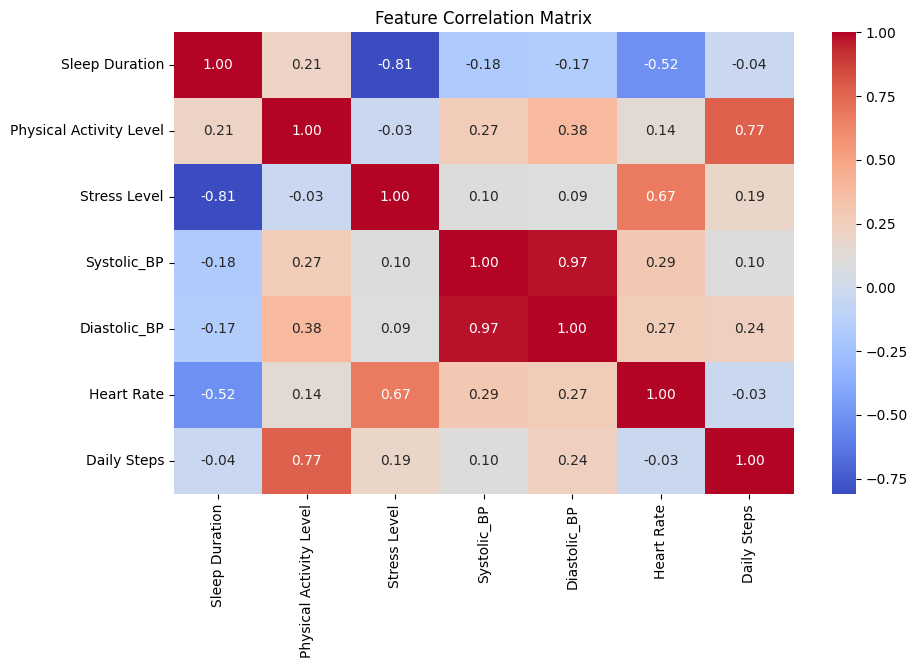

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Sleep Duration', 'Physical Activity Level', 'Stress Level',
                'Systolic_BP', 'Diastolic_BP', 'Heart Rate', 'Daily Steps']].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [7]:
# KNN Similar user group predictions
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(df_scaled, df['Sleep Disorder Encoded'])

df["Similar_User_Group"] = knn.predict(df_scaled)

In [8]:
#df.to_csv("processed_sleep_data.csv", index=False)

In [9]:
X = df_scaled
y = df["Quality of Sleep"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (32, 16)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.005, 0.01]
}


mlp = MLPRegressor(max_iter=1000, random_state=0, early_stopping=True)
grid_search = GridSearchCV(mlp, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)



Best Parameters: {'alpha': 0.01, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.005}


In [10]:
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)

# mse scoring
mse = mean_squared_error(y_test, y_pred)
print(f"Predicting sleep improvement MSE: {mse:.4f}")

Predicting sleep improvement MSE: 0.0003


/var/folders/d5/v0w7v20x70z55jvhywdpp06h0000gn/T/ipykernel_83292/3870170506.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


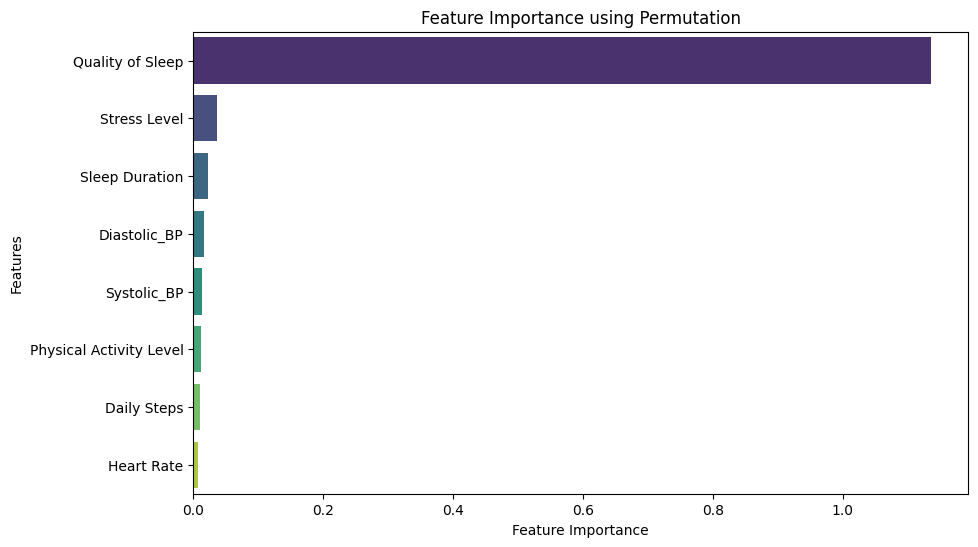

In [11]:
# Permutation Importance
perm_importance = permutation_importance(best_mlp, X_test, y_test, n_repeats=10, random_state=42)

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance using Permutation")
plt.show()

In [12]:
# VIF calculation to check for multicollinearity 1st try
X = df[['Sleep Duration', 'Physical Activity Level', 'Stress Level', 'Systolic_BP', 'Diastolic_BP', 'Heart Rate', 'Daily Steps']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                   Feature        VIF
0           Sleep Duration   3.781482
1  Physical Activity Level   5.366363
2             Stress Level   5.651243
3              Systolic_BP  30.525038
4             Diastolic_BP  33.143256
5               Heart Rate   3.384810
6              Daily Steps   5.518784


In [13]:
df["Mean_BP"] = (df["Systolic_BP"] + df["Diastolic_BP"]) / 2
df.drop(columns=["Systolic_BP", "Diastolic_BP"], inplace=True)

In [14]:
# VIF calculation to check for multicollinearity 2nd try
X = df[['Sleep Duration', 'Physical Activity Level', 'Stress Level', 'Mean_BP', 'Heart Rate', 'Daily Steps']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                   Feature       VIF
0           Sleep Duration  3.665816
1  Physical Activity Level  5.336029
2             Stress Level  5.368720
3                  Mean_BP  1.339701
4               Heart Rate  3.371197
5              Daily Steps  4.921251
